In [4]:
import pandas as pd
from joblib import load

In [5]:
final_svc = load('../Model and Scaler/final_svc.joblib')
final_scaler = load('../Model and Scaler/final_scaler.joblib')

In [6]:
upcoming = pd.read_csv('../Predictions/Data/upcoming-event.csv').loc[:, ["R_fighter", "R_odds", "R_ev", "R_avg_SIG_STR_pct", "R_avg_TD_pct", "R_current_win_streak",
                                                     "r_ko_odds", "r_sub_odds",
                            
                                                     "B_fighter", "B_odds", "B_ev", "B_avg_SIG_STR_pct", "B_avg_TD_pct", "B_current_win_streak",
                                                     "b_ko_odds", "b_sub_odds",
                                                     "Winner"]]

### Dropping Johns vs. Dos Santos since bout was canceled

In [7]:
upcoming.drop(8, axis=0, inplace=True)
upcoming = upcoming.reset_index().drop("index", axis=1)

In [8]:
upcoming.isnull().sum()

R_fighter                0
R_odds                   0
R_ev                     0
R_avg_SIG_STR_pct        0
R_avg_TD_pct             0
R_current_win_streak     0
r_ko_odds                0
r_sub_odds               0
B_fighter                0
B_odds                   0
B_ev                     0
B_avg_SIG_STR_pct        0
B_avg_TD_pct             0
B_current_win_streak     0
b_ko_odds                0
b_sub_odds               0
Winner                  10
dtype: int64

In [9]:
X = upcoming.drop(["R_fighter", "B_fighter", "Winner"], axis=1)

In [10]:
scaled_X = final_scaler.transform(X)

In [11]:
predictions = final_svc.predict(scaled_X)

In [12]:
probabilities = final_svc.predict_proba(scaled_X)

In [13]:
predictions

array(['Red', 'Blue', 'Blue', 'Red', 'Red', 'Red', 'Red', 'Red', 'Red',
       'Blue'], dtype=object)

In [14]:
probabilities

array([[0.26940415, 0.73059585],
       [0.5306327 , 0.4693673 ],
       [0.68865264, 0.31134736],
       [0.32215564, 0.67784436],
       [0.35045958, 0.64954042],
       [0.29948393, 0.70051607],
       [0.28230097, 0.71769903],
       [0.38217229, 0.61782771],
       [0.2718782 , 0.7281218 ],
       [0.51804806, 0.48195194]])

In [15]:
formatted = upcoming[["R_fighter", "B_fighter"]]
formatted

,R_fighter,B_fighter
0,Islam Makhachev,Thiago Moises
1,Marion Reneau,Miesha Tate
2,Jeremy Stephens,Mateusz Gamrot
3,Rodolfo Vieira,Dustin Stoltzfus
4,Gabriel Benitez,Billy Quarantillo
5,Daniel Rodriguez,Preston Parsons
6,Amanda Lemos,Montserrat Conejo
7,Khalid Taha,Sergey Morozov
8,Francisco Figueiredo,Malcolm Gordon
9,Alan Baudot,Rodrigo Nascimento


In [16]:
ser_pred = pd.DataFrame(data=pd.Series(predictions, name="Predictions"))
formatted = formatted.merge(ser_pred, on=formatted.index)

In [17]:
formatted.drop("key_0", axis=1, inplace=True)

In [18]:
R_win_prob_df = pd.DataFrame(pd.Series([item[1] for item in probabilities], name="R_fighter_win_prob"))
B_win_prob_df = pd.DataFrame(pd.Series([item[0] for item in probabilities], name="B_fighter_win_prob"))

In [19]:
formatted = formatted.merge(R_win_prob_df, on=formatted.index)
formatted.drop("key_0", axis=1, inplace=True)

In [20]:
formatted = formatted.merge(B_win_prob_df, on=formatted.index)
formatted.drop("key_0", axis=1, inplace=True)

In [21]:
raw_pred = formatted.loc[:, ["R_fighter", "B_fighter", "Predictions"]]

In [22]:
formatted = formatted.drop("Predictions", axis=1)

In [23]:
formatted = formatted.rename(columns={"R_fighter_win_prob": "R_prob", "B_fighter_win_prob": "B_prob"})

In [24]:
raw_pred

,R_fighter,B_fighter,Predictions
0,Islam Makhachev,Thiago Moises,Red
1,Marion Reneau,Miesha Tate,Blue
2,Jeremy Stephens,Mateusz Gamrot,Blue
3,Rodolfo Vieira,Dustin Stoltzfus,Red
4,Gabriel Benitez,Billy Quarantillo,Red
5,Daniel Rodriguez,Preston Parsons,Red
6,Amanda Lemos,Montserrat Conejo,Red
7,Khalid Taha,Sergey Morozov,Red
8,Francisco Figueiredo,Malcolm Gordon,Red
9,Alan Baudot,Rodrigo Nascimento,Blue


In [25]:
formatted

,R_fighter,B_fighter,R_prob,B_prob
0,Islam Makhachev,Thiago Moises,0.730596,0.269404
1,Marion Reneau,Miesha Tate,0.469367,0.530633
2,Jeremy Stephens,Mateusz Gamrot,0.311347,0.688653
3,Rodolfo Vieira,Dustin Stoltzfus,0.677844,0.322156
4,Gabriel Benitez,Billy Quarantillo,0.649540,0.350460
5,Daniel Rodriguez,Preston Parsons,0.700516,0.299484
6,Amanda Lemos,Montserrat Conejo,0.717699,0.282301
7,Khalid Taha,Sergey Morozov,0.617828,0.382172
8,Francisco Figueiredo,Malcolm Gordon,0.728122,0.271878
9,Alan Baudot,Rodrigo Nascimento,0.481952,0.518048


In [26]:
formatted.to_csv('../Predictions/task-final-submission.csv')

# Correct:
* Baudot vs. Nascimento
* Lemos vs. Conejo
* Rodriguez vs. Parsons
* Stephens vs. Gamrot
* Reneau vs. Tate
* Vieira vs. Stoltzfus
* Makhachev vs. Moises

# Incorrect:
* Figueiredo vs. Gordon
* Taha vs. Morozov
* Benitez vs. Quarantillo

In [27]:
true = raw_pred.Predictions
true[4], true[7], true[8] = "Blue", "Blue", "Blue"

In [28]:
from sklearn.metrics import plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt

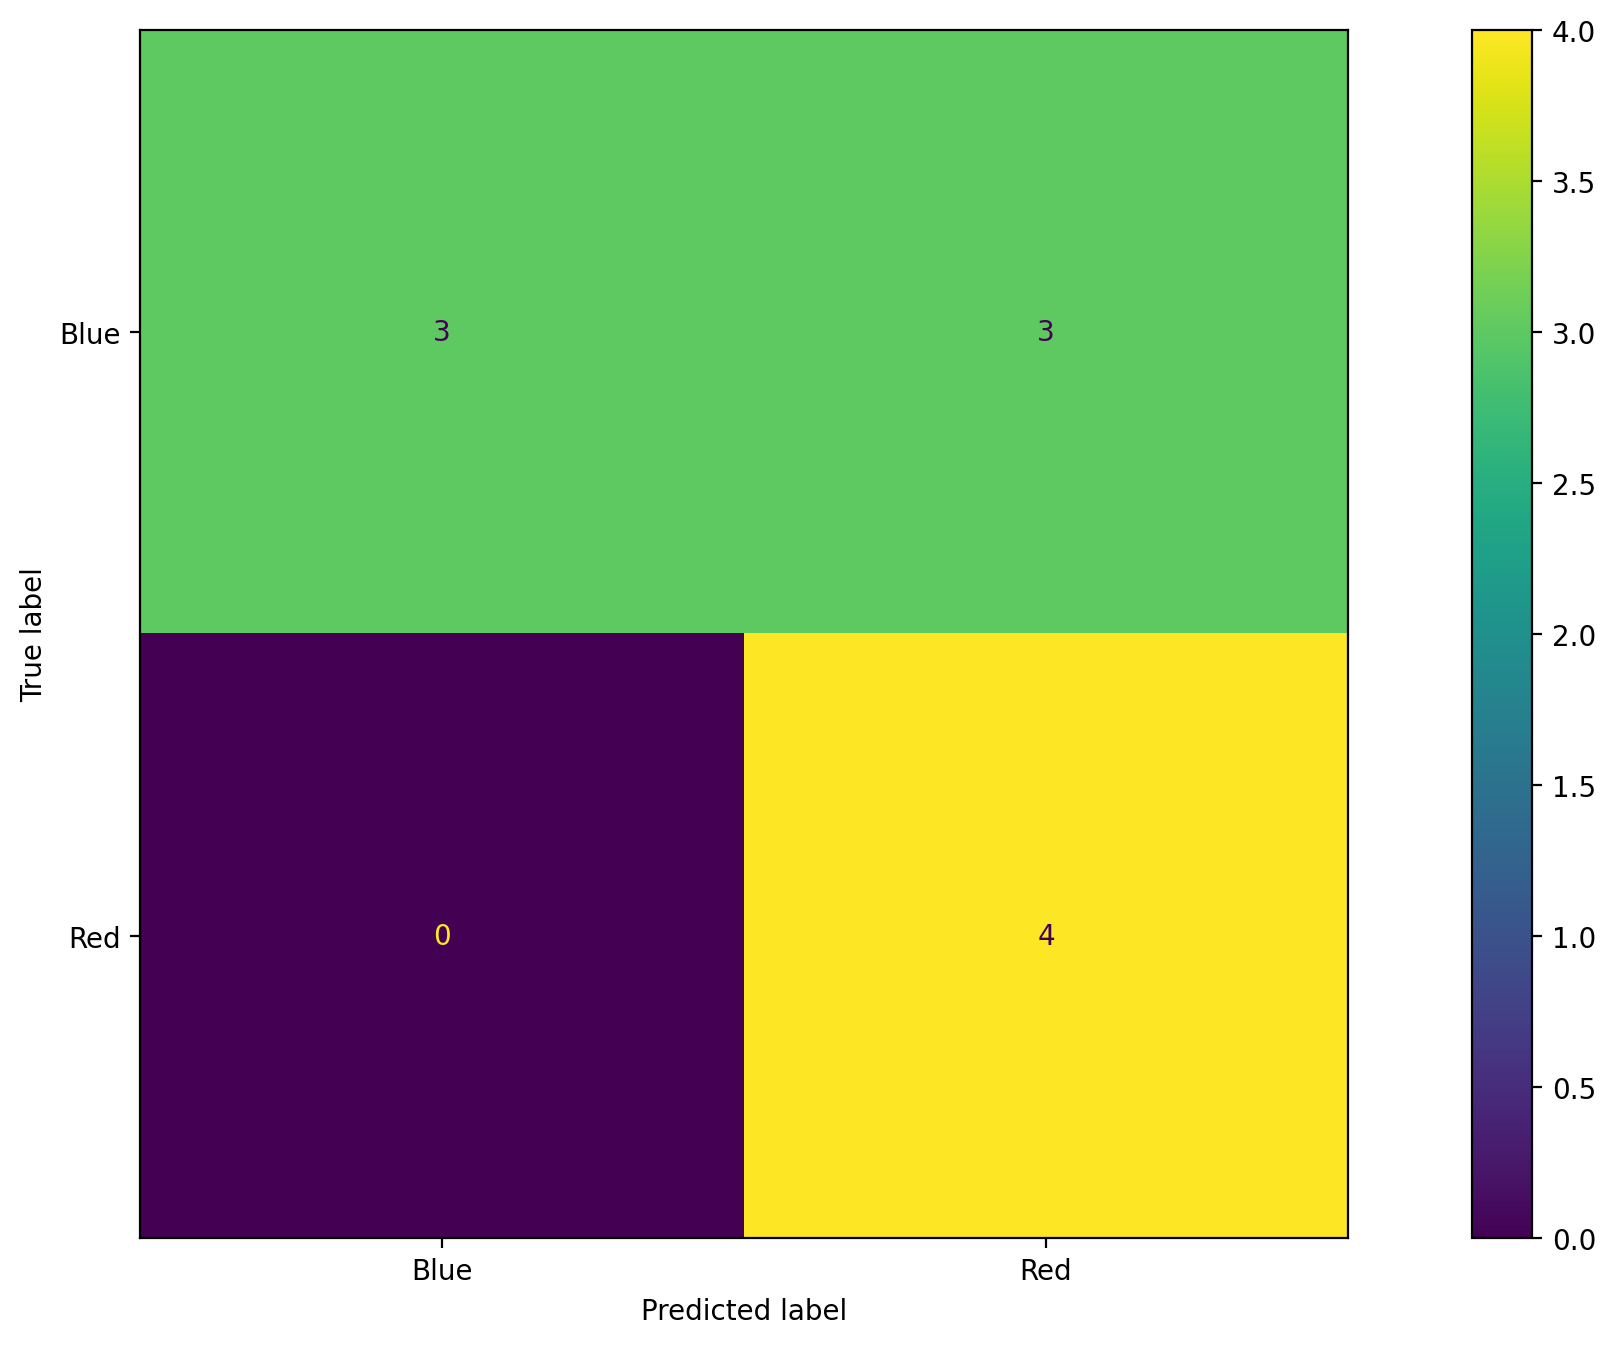

In [29]:
fig, ax = plt.subplots(figsize=(16,8), dpi=200)
plot_confusion_matrix(final_svc, scaled_X, true, ax=ax)
plt.show();

In [30]:
print(classification_report(true, predictions))

              precision    recall  f1-score   support

        Blue       1.00      0.50      0.67         6
         Red       0.57      1.00      0.73         4

    accuracy                           0.70        10
   macro avg       0.79      0.75      0.70        10
weighted avg       0.83      0.70      0.69        10

